<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imporando-Pacotes" data-toc-modified-id="Imporando-Pacotes-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imporando Pacotes</a></span></li><li><span><a href="#Função-de-Entrada" data-toc-modified-id="Função-de-Entrada-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Função de Entrada</a></span></li><li><span><a href="#Dicionários" data-toc-modified-id="Dicionários-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Dicionários</a></span></li><li><span><a href="#Cenários" data-toc-modified-id="Cenários-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Cenários</a></span></li><li><span><a href="#viz" data-toc-modified-id="viz-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>viz</a></span></li><li><span><a href="#Cruzando-com-indicadores" data-toc-modified-id="Cruzando-com-indicadores-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Cruzando com indicadores</a></span></li><li><span><a href="#Otimização" data-toc-modified-id="Otimização-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Otimização</a></span></li></ul></div>

# Imporando Pacotes

In [1]:
# Importando as bibliotecas
import numpy as np # pacote para funções matemáticas
import pandas as pd # pacote para a manipulação dos dados em tabela
from IPython.display import display # Allows the use of display() for DataFrames
import matplotlib.pyplot as plt # pacote para fazer gráficos
import matplotlib.patches as mpatches
import seaborn as sns
import datetime as dt
import plotly.express as px
import plotly.graph_objects as go


import pandas_ta as ta
import talib
import mplfinance as mpf

import optuna
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

pd.set_option("display.max_columns", 40)
pd.set_option('display.max_rows', 500)

C:\Users\User\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\User\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
from futures_backtester import Backtester

# Função de Entrada

In [649]:
def entrada(df, length_rsi, rsi_low, rsi_high, allowed_hours=None, position_type="both"):

    df = df.copy()  # Para evitar SettingWithCopyWarning
    
    
    # RSI
    df['rsi'] = df.ta.rsi(length=length_rsi).fillna(0)
    #ADX
    df['adx'] = df.ta.adx(length=compr)['ADX_'+str(compr)]
    
    # VWAP
    df['vwap'] = df.ta.vwap(high='high', low='low', close='close', volume='volume')
    
    # Condições de entrada
    price = df['close']
    cond_long = (price > df['vwap']) & (price.shift(1) <= df['vwap'].shift(1)) & (df['rsi'] > rsi_high) #& (df['adx'] < 20)
    cond_short = (price < df['vwap']) & (price.shift(1) >= df['vwap'].shift(1)) & (df['rsi'] > rsi_low) #& (df['rsi'] < 20)

    df['position'] = 0
    if position_type == "short":
        df.loc[cond_short, "position"] = -1
    elif position_type == "long":
        df.loc[cond_long, "position"] = +1
    else:
        df.loc[cond_long, "position"] = -1
        df.loc[cond_short, "position"] = +1

    # Restrição de horário
    if allowed_hours is not None:
        df.loc[~df.index.to_series().dt.hour.isin(allowed_hours), 'position'] = 0
        
    df.loc[(df.index.to_series().dt.hour==9) & (df.index.to_series().dt.minute<=10), 'position'] = 0

    return df['position']

# Dicionários

In [650]:
from config.dicts_params import dict_custos, dict_valor_lot, dict_path

# Cenários

In [651]:
# win 5 min
{'sl': 300, 'tp': 620, 'LENGTH_RSI': 13, 'RSI_LOW': 30, 'RSI_HIGH': 70}


# win 2 min


# wdo 5 min
{'sl': 8.0, 'tp': 6.0, 'LENGTH_RSI': 6, 'RSI_LOW': 0, 'RSI_HIGH': 0}

# wsp

# USDJPY 5 min


{'sl': 300, 'tp': 620, 'LENGTH_RSI': 13, 'RSI_LOW': 30, 'RSI_HIGH': 70}

In [770]:
params = {'sl': 500, 'tp': 200, 'LENGTH_RSI': 6, 'RSI_LOW': 30, 'RSI_HIGH': 30}
params = {'sl': 5.0, 'tp': 2.5, 'LENGTH_RSI': 6, 'RSI_LOW': 0, 'RSI_HIGH': 0}

In [773]:
# Configurar o backtester
sym = 'WIN@N'
#sym = 'WSP@N'
#sym = 'BIT@N'
sym = 'WDO@N'
#sym = 'EURJPY'
#sym = 'GBPJPY'
#sym = 'USDJPY'



bt = Backtester(
    symbol = sym,
    timeframe = 't2',
    data_ini = '2019-01-01',
    data_fim = '2024-06-15',
    tp = params['tp'],
    sl = params['sl'],
    slippage = 0,
    tc = dict_custos[sym], # $ per lot
    lote = 1,
    valor_lote= dict_valor_lot[sym],
    initial_cash = 30000,
    path_base= dict_path[sym],
    daytrade = True
)


# Parâmetros da estratégia RSI
LENGTH_RSI = params['LENGTH_RSI']
RSI_LOW = params['RSI_LOW']
RSI_HIGH = params['RSI_HIGH']

# Executa o backtest com a estratégia RSI
df, metrics = bt.run(
    signal_function=entrada, 
    signal_args={
        "length_rsi": LENGTH_RSI,
        "rsi_low": RSI_LOW,
        "rsi_high": RSI_HIGH,
        #'allowed_hours': [9,10,11,12,13,14,15,16,17],
        'allowed_hours': [16],
        'position_type': "both"
    }
)


# Print de métricas
bt.print_metrics(metrics)

RELATÓRIO DE DESEMPENHO
Símbolo: WDO@N
Timeframe: t2
Período: 2019-01-01 a 2024-06-15

--- RESULTADOS ---
Saldo Inicial: $30000.00
Saldo Final: $34590.00
Retorno Total: $4590.00 (15.30%)
Retorno Anualizado: 14.44%
Volatilidade Anualizada: 3.36%

--- DRAWDOWN ---
Drawdown Máximo: 1.22%
Drawdown Máximo (Valor): $379.20
Tempo Máximo em Drawdown: 36729.0 períodos
Tempo em Drawdown: 83.24% do total

--- TRADES ---
Total de Trades: 900
Trades Vencedores: 685 (76.11%)
Trades Perdedores: 215 (23.89%)
Saídas por TP: 75.89%
Saídas por SL: 22.67%
Saídas por Tempo: 1.44%

--- RATIOS ---
Sharpe Ratio: 4.293
Sortino Ratio: 12.277
Calmar Ratio: 11.841
Profit Factor: 1.423

--- ANÁLISE DE GANHOS/PERDAS ---
Ganho Médio: $22.55
Perda Média: $50.49
Win/Loss Ratio: 0.45
Expectancy: $5.10


<module 'matplotlib.pyplot' from 'C:\\Users\\User\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

<Figure size 1400x1000 with 0 Axes>

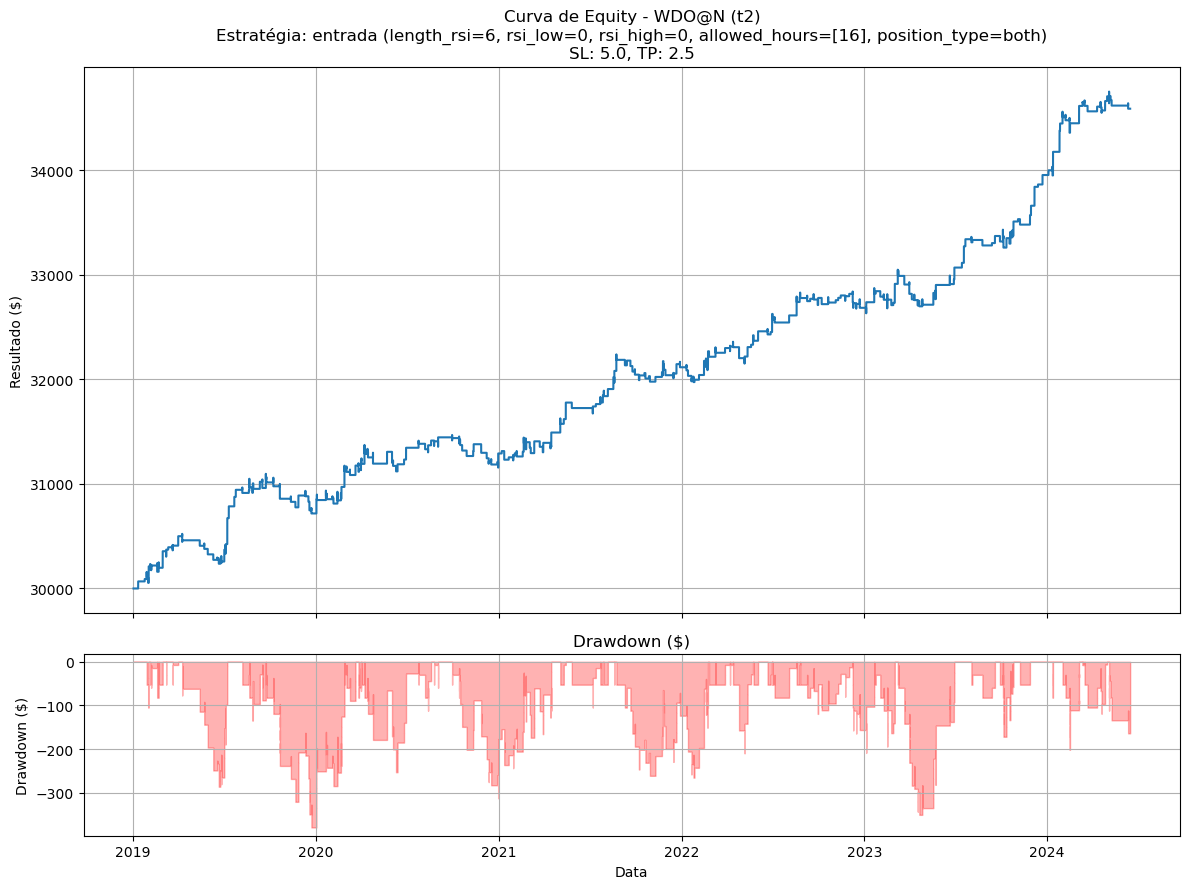

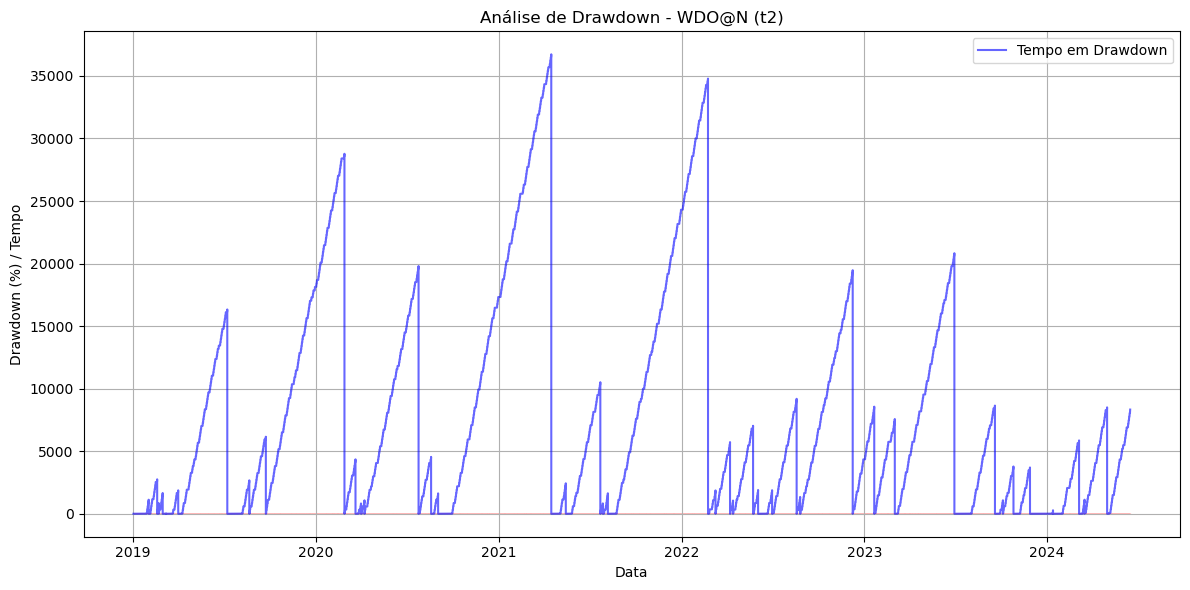

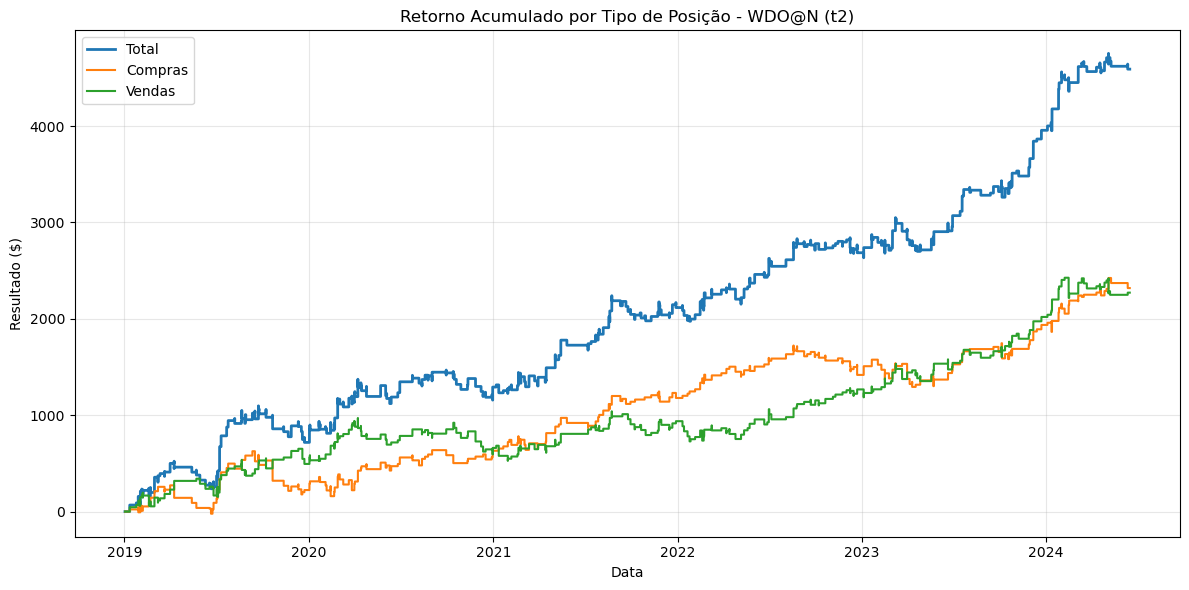

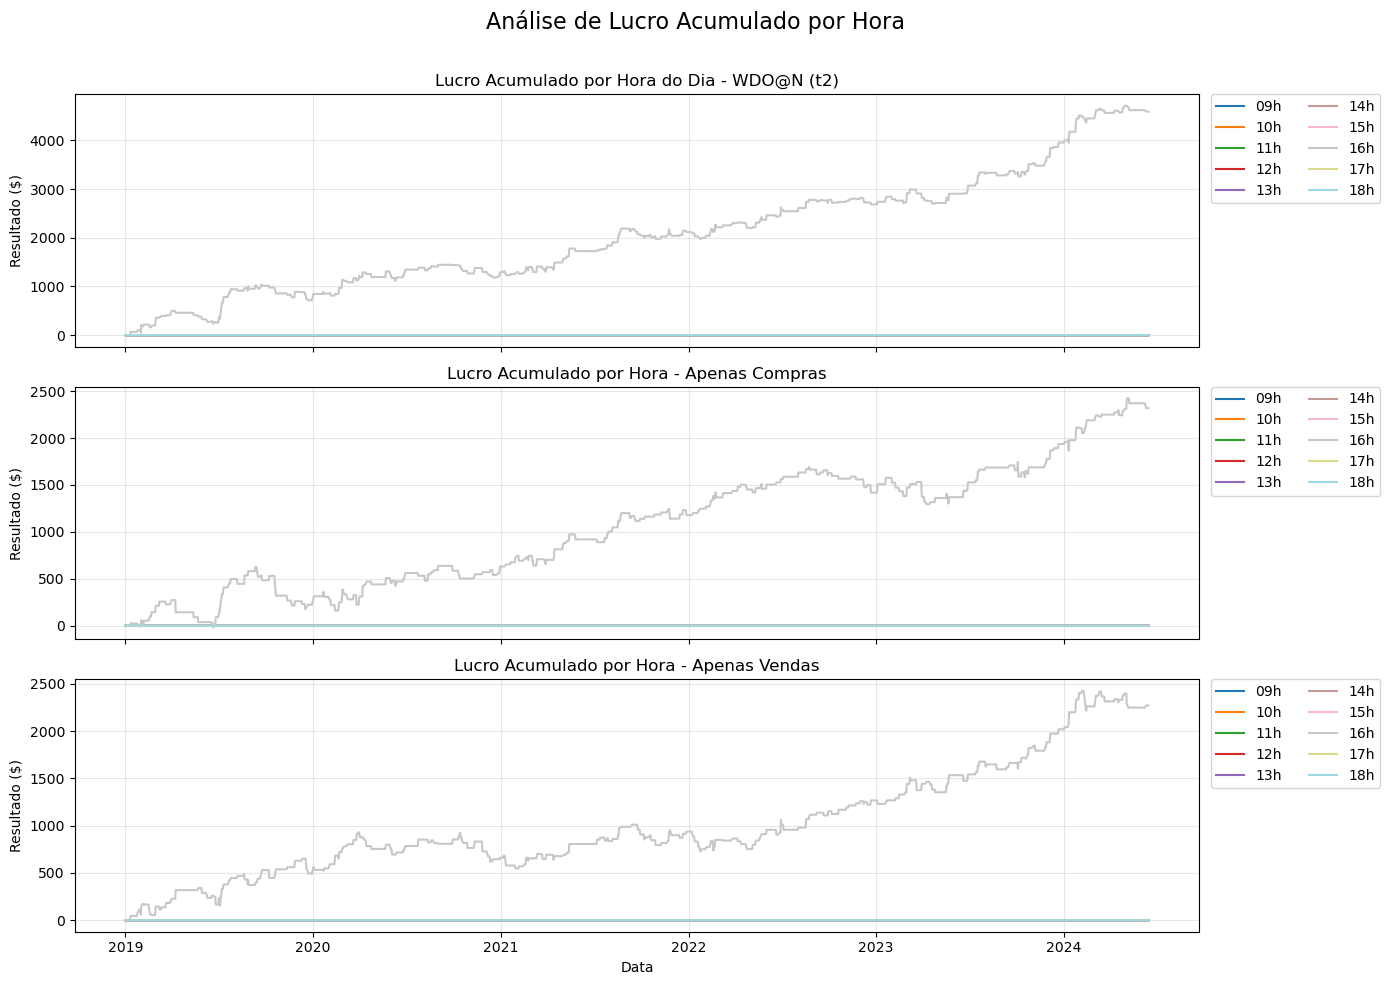

In [774]:
# Plotar a curva de equity com drawdown
plt.figure(figsize=(14, 10))

# 1. Curva de equity
plt = bt.plot_equity_curve(include_drawdown=True)

# 2. Análise detalhada de drawdown
plt = bt.plot_drawdown()

# 3. resultado por hora
bt.plot_by_position()
bt.plot_cumulative_by_hour()

In [743]:
#bt.plot_profit_by_hour()

# viz

In [725]:
df['vwap'] = df.ta.vwap(high='high', low='low', close='close', volume='volume')
df['v_minus_c'] = df['vwap'] - df['close']
df['pct_v_minus_c'] = (df['vwap'] - df['close'])/df['vwap']

In [726]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_vwap_estrategia(df, start='2021-06-22', end='2021-06-26'):
    """
    Plota estratégia VWAP com gráfico de velas usando Plotly
    
    Args:
        df: DataFrame com colunas ['open', 'high', 'low', 'close', 'vwap', 'position']
        start: Data de início (string)
        end: Data de fim (string)
    """
    df_plot = df.loc[start:end].copy()
    
    # Cria o gráfico
    fig = go.Figure()
    
    # Adiciona gráfico de velas
    fig.add_trace(go.Candlestick(
        x=df_plot.index,
        open=df_plot['open'],
        high=df_plot['high'],
        low=df_plot['low'],
        close=df_plot['close'],
        name='Preço',
        increasing_line_color='green',
        decreasing_line_color='red'
    ))
    
    # Adiciona linha VWAP
    fig.add_trace(go.Scatter(
        x=df_plot.index,
        y=df_plot['vwap'],
        mode='lines',
        name='VWAP',
        line=dict(color='orange', dash='dash', width=2)
    ))
    
    # Marca entradas longas
    long_signals = df_plot[df_plot['position'] == 1]
    if not long_signals.empty:
        fig.add_trace(go.Scatter(
            x=long_signals.index,
            y=long_signals['close'],
            mode='markers',
            name='Entrada Long',
            marker=dict(
                symbol='triangle-up',
                size=12,
                color='green',
                line=dict(color='darkgreen', width=1)
            )
        ))
    
    # Marca entradas short
    short_signals = df_plot[df_plot['position'] == -1]
    if not short_signals.empty:
        fig.add_trace(go.Scatter(
            x=short_signals.index,
            y=short_signals['close'],
            mode='markers',
            name='Entrada Short',
            marker=dict(
                symbol='triangle-down',
                size=12,
                color='red',
                line=dict(color='darkred', width=1)
            )
        ))
    
    # Configurações do layout
    fig.update_layout(
        title=f'Estratégia VWAP com RSI | Período: {start} a {end}',
        xaxis_title='Data',
        yaxis_title='Preço',
        width=1200,
        height=600,
        showlegend=True,
        xaxis_rangeslider_visible=False,  # Remove o slider de range
        template='plotly_white'
    )
    
    # Configurações do grid
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
    
    fig.show()

# Versão alternativa com subplot para volume (caso você tenha dados de volume)
def plot_vwap_estrategia_com_volume(df, start='2021-06-22', end='2021-06-26'):
    """
    Versão com subplot para volume
    
    Args:
        df: DataFrame com colunas ['open', 'high', 'low', 'close', 'volume', 'vwap', 'position']
        start: Data de início (string)
        end: Data de fim (string)
    """
    df_plot = df.loc[start:end].copy()
    
    # Cria subplots
    fig = make_subplots(
        rows=2, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.05,
        row_heights=[0.8, 0.2],
        subplot_titles=('Preço e VWAP', 'Volume')
    )
    
    # Gráfico de velas no subplot superior
    fig.add_trace(go.Candlestick(
        x=df_plot.index,
        open=df_plot['open'],
        high=df_plot['high'],
        low=df_plot['low'],
        close=df_plot['close'],
        name='Preço',
        increasing_line_color='green',
        decreasing_line_color='red'
    ), row=1, col=1)
    
    # VWAP
    fig.add_trace(go.Scatter(
        x=df_plot.index,
        y=df_plot['vwap'],
        mode='lines',
        name='VWAP',
        line=dict(color='orange', dash='dash', width=2)
    ), row=1, col=1)
    
    # Entradas longas
    long_signals = df_plot[df_plot['position'] == 1]
    if not long_signals.empty:
        fig.add_trace(go.Scatter(
            x=long_signals.index,
            y=long_signals['close'],
            mode='markers',
            name='Entrada Long',
            marker=dict(
                symbol='triangle-up',
                size=12,
                color='green',
                line=dict(color='darkgreen', width=1)
            )
        ), row=1, col=1)
    
    # Entradas short
    short_signals = df_plot[df_plot['position'] == -1]
    if not short_signals.empty:
        fig.add_trace(go.Scatter(
            x=short_signals.index,
            y=short_signals['close'],
            mode='markers',
            name='Entrada Short',
            marker=dict(
                symbol='triangle-down',
                size=12,
                color='red',
                line=dict(color='darkred', width=1)
            )
        ), row=1, col=1)
    
    # Volume no subplot inferior (se existir)
    if 'volume' in df_plot.columns:
        fig.add_trace(go.Bar(
            x=df_plot.index,
            y=df_plot['volume'],
            name='Volume',
            marker_color='blue',
            opacity=0.7
        ), row=2, col=1)
    
    # Layout
    fig.update_layout(
        title=f'Estratégia VWAP com RSI | Período: {start} a {end}',
        width=1200,
        height=800,
        showlegend=True,
        xaxis_rangeslider_visible=False,
        template='plotly_white'
    )
    
    # Labels dos eixos
    fig.update_yaxes(title_text="Preço", row=1, col=1)
    fig.update_yaxes(title_text="Volume", row=2, col=1)
    fig.update_xaxes(title_text="Data", row=2, col=1)
    
    # Grid
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
    
    fig.show()

In [238]:
def plot_vwap_estrategia_com_volume_e_lucro(df, start='2021-06-22', end='2021-06-26'):
    """
    Versão com subplots para volume e lucro acumulado
    
    Args:
        df: DataFrame com colunas ['open', 'high', 'low', 'close', 'volume', 'vwap', 'position', 'strategy']
        start: Data de início (string)
        end: Data de fim (string)
    """
    df_plot = df.loc[start:end].copy()
    
    # Calcula lucro acumulado
    df_plot['lucro_acumulado'] = df_plot['strategy'].cumsum()
    
    # Cria subplots com 3 linhas
    fig = make_subplots(
        rows=3, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.03,
        row_heights=[0.6, 0.2, 0.2],
        subplot_titles=('Preço e VWAP', 'Volume', 'Lucro Acumulado')
    )
    
    # Gráfico de velas no subplot superior
    fig.add_trace(go.Candlestick(
        x=df_plot.index,
        open=df_plot['open'],
        high=df_plot['high'],
        low=df_plot['low'],
        close=df_plot['close'],
        name='Preço',
        increasing_line_color='green',
        decreasing_line_color='red'
    ), row=1, col=1)
    
    # VWAP
    fig.add_trace(go.Scatter(
        x=df_plot.index,
        y=df_plot['vwap'],
        mode='lines',
        name='VWAP',
        line=dict(color='orange', dash='dash', width=2)
    ), row=1, col=1)
    
    # Entradas longas
    long_signals = df_plot[df_plot['position'] == 1]
    if not long_signals.empty:
        fig.add_trace(go.Scatter(
            x=long_signals.index,
            y=long_signals['close'],
            mode='markers',
            name='Entrada Long',
            marker=dict(
                symbol='triangle-up',
                size=12,
                color='green',
                line=dict(color='darkgreen', width=1)
            )
        ), row=1, col=1)
    
    # Entradas short
    short_signals = df_plot[df_plot['position'] == -1]
    if not short_signals.empty:
        fig.add_trace(go.Scatter(
            x=short_signals.index,
            y=short_signals['close'],
            mode='markers',
            name='Entrada Short',
            marker=dict(
                symbol='triangle-down',
                size=12,
                color='red',
                line=dict(color='darkred', width=1)
            )
        ), row=1, col=1)
    
    # Volume no segundo subplot (se existir)
    if 'volume' in df_plot.columns:
        fig.add_trace(go.Bar(
            x=df_plot.index,
            y=df_plot['volume'],
            name='Volume',
            marker_color='blue',
            opacity=0.7,
            showlegend=False
        ), row=2, col=1)
    
    # Lucro acumulado no terceiro subplot
    fig.add_trace(go.Scatter(
        x=df_plot.index,
        y=df_plot['lucro_acumulado'],
        mode='lines',
        name='Lucro Acumulado',
        line=dict(color='purple', width=2),
        fill='tonexty' if df_plot['lucro_acumulado'].iloc[0] >= 0 else None,
        showlegend=True
    ), row=3, col=1)
    
    # Linha zero para referência no lucro acumulado
    fig.add_hline(y=0, line_dash="dash", line_color="gray", 
                  opacity=0.5, row=3, col=1)
    
    # Layout
    fig.update_layout(
        title=f'Estratégia VWAP com RSI | Período: {start} a {end}',
        width=1200,
        height=1000,
        showlegend=True,
        xaxis_rangeslider_visible=False,
        template='plotly_white'
    )
    
    # Labels dos eixos
    fig.update_yaxes(title_text="Preço", row=1, col=1)
    fig.update_yaxes(title_text="Volume", row=2, col=1)
    fig.update_yaxes(title_text="Lucro Acumulado", row=3, col=1)
    fig.update_xaxes(title_text="Data", row=3, col=1)
    
    # Grid
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
    
    # Calcula e mostra estatísticas do lucro
    lucro_total = df_plot['lucro_acumulado'].iloc[-1]
    lucro_maximo = df_plot['lucro_acumulado'].max()
    lucro_minimo = df_plot['lucro_acumulado'].min()
    
    print(f"Estatísticas do Período ({start} a {end}):")
    print(f"Lucro Total: {lucro_total:.4f}")
    print(f"Lucro Máximo: {lucro_maximo:.4f}")
    print(f"Lucro Mínimo: {lucro_minimo:.4f}")
    print(f"Drawdown Máximo: {lucro_maximo - lucro_minimo:.4f}")
    
    fig.show()

In [240]:
plot_vwap_estrategia_com_volume_e_lucro(df, start='2024-06-05', end='2024-06-26')

Estatísticas do Período (2024-06-05 a 2024-06-26):
Lucro Total: -203.0000
Lucro Máximo: 162.0000
Lucro Mínimo: -372.0000
Drawdown Máximo: 534.0000


<AxesSubplot:xlabel='time'>

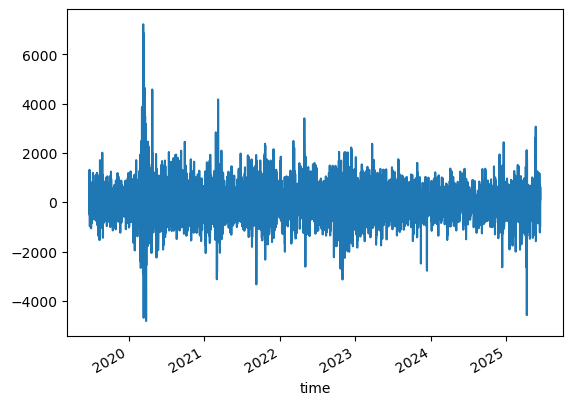

In [231]:
df['v_minus_c'].loc['2019-06-01':'2025-06-26'].plot()

# Cruzando com indicadores

In [765]:
def plot_rsi_profit(compr, nquantis, df, direction='both'):
    
    df2 = df.copy()
    
    df2['rsi'] = df2.ta.rsi(length=compr)
    df2['rsi'] = df2['rsi'].fillna(0)
    df2['bin_rsi'] = pd.qcut(df2['rsi'], nquantis)   

    if direction=='both':
        pass    
    elif direction=='long':
        df2.loc[df2['position']==-1, 'strategy'] = 0    
    elif direction=='short':
        df2.loc[df2['position']==+1, 'strategy'] = 0    
    
    df2['cstrategy'] = df2['strategy'].cumsum()
    for hora in df2.index.hour.unique():
        df2['strategy_'+str(hora)] = 0.0
        df2.loc[df2.index.hour==hora,'strategy_'+str(hora)] = df2[df2.index.hour==hora]['strategy']
        df2['cstrategy_'+str(hora)] = df2['strategy_'+str(hora)].cumsum()

    colunas = [ 'bin_rsi','strategy', 'strategy_9','strategy_10','strategy_11','strategy_12','strategy_13',
              'strategy_14','strategy_15','strategy_16','strategy_17']

    # Dataframe com RSI e retornos médios por operação
    dfrsi = df2[df2['position']!=0][colunas].groupby(['bin_rsi'], observed=True).mean().round(2)

    #Plot
    dfrsi.iloc[:,1:].plot(kind='bar',figsize = (10,6))

In [766]:
def plot_adx_profit(compr, nquantis, df, direction='both'):
    
    df2 = df.copy()
    
    df2['rsi'] = df2.ta.rsi(length=compr)
    df2['adx'] = df2.ta.adx(length=compr)['ADX_'+str(compr)]
    df2['bin_rsi'] = pd.qcut(df2['adx'], nquantis)   

    if direction=='both':
        pass    
    elif direction=='long':
        df2.loc[df2['position']==-1, 'strategy'] = 0    
    elif direction=='short':
        df2.loc[df2['position']==+1, 'strategy'] = 0    
    
    df2['cstrategy'] = df2['strategy'].cumsum()
    for hora in df2.index.hour.unique():
        df2['strategy_'+str(hora)] = 0.0
        df2.loc[df2.index.hour==hora,'strategy_'+str(hora)] = df2[df2.index.hour==hora]['strategy']
        df2['cstrategy_'+str(hora)] = df2['strategy_'+str(hora)].cumsum()

    colunas = [ 'bin_rsi','strategy', 'strategy_9','strategy_10','strategy_11','strategy_12','strategy_13',
              'strategy_14','strategy_15','strategy_16','strategy_17']

    # Dataframe com RSI e retornos médios por operação
    dfrsi = df2[df2['position']!=0][colunas].groupby(['bin_rsi'], observed=True).mean().round(2)

    #Plot
    dfrsi.iloc[:,1:].plot(kind='bar',figsize = (10,6))

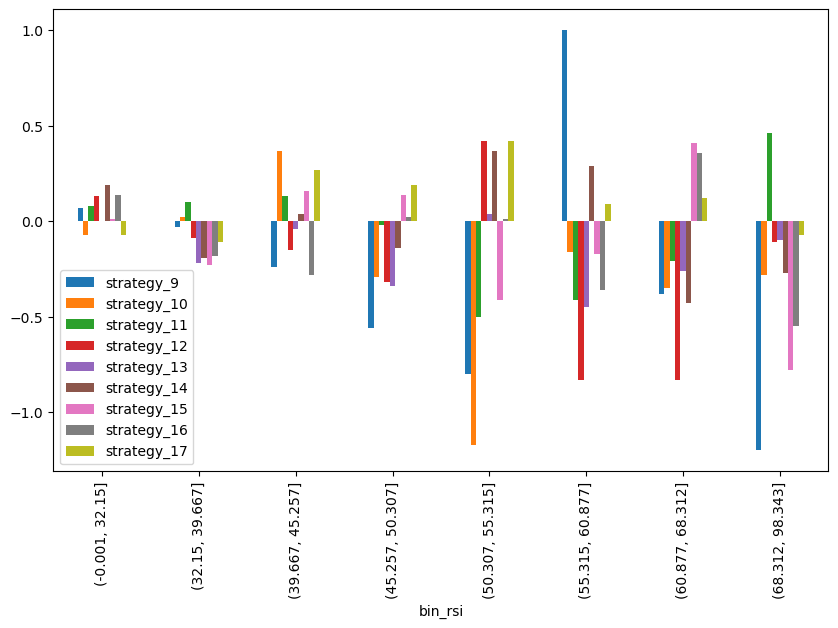

In [767]:
compr = 8
nquantis = 8
plot_rsi_profit(compr, nquantis, df, direction='short')

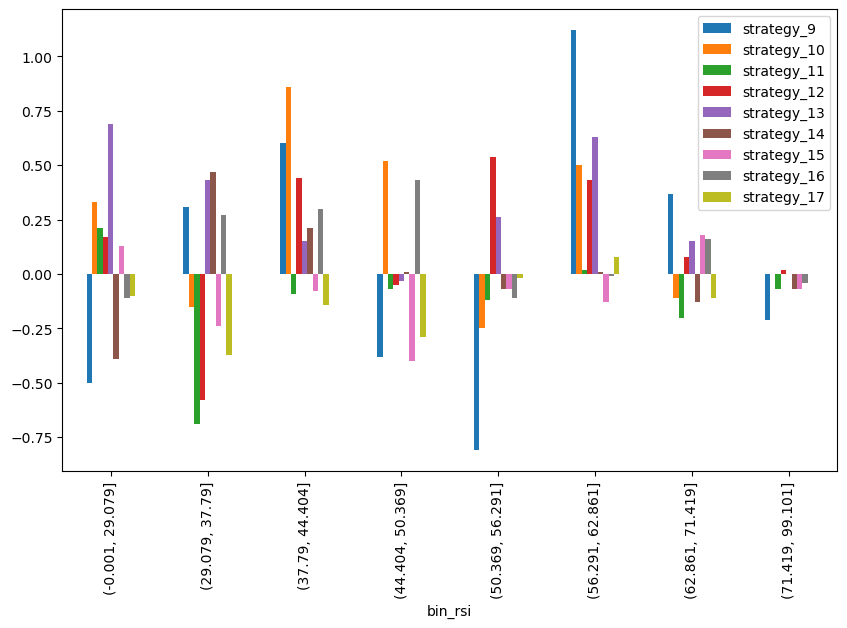

In [768]:
compr = 6
nquantis = 8
plot_rsi_profit(compr, nquantis, df, direction='long')

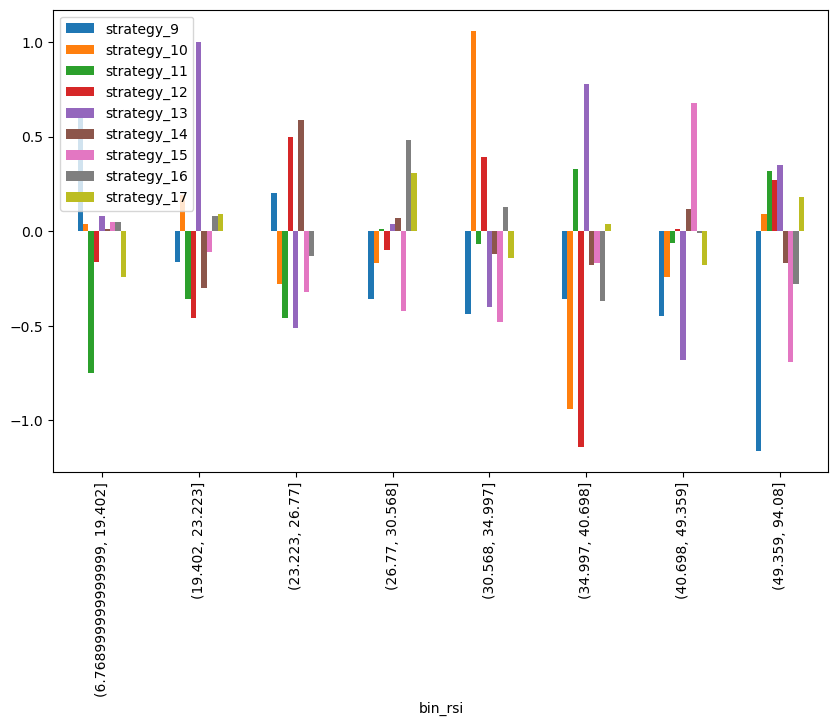

In [769]:
compr = 8
nquantis = 8
plot_adx_profit(compr, nquantis, df, direction='both')

# Otimização

In [9]:
metrics

{'initial_cash': 30000,
 'final_equity': 148663.0,
 'total_return': 118663.0,
 'total_return_pct': 395.54333333333335,
 'annual_return': 31.44768159985931,
 'annual_volatility': 19.604626512650096,
 'total_trades': 4524,
 'win_trades': 1342,
 'loss_trades': 3181,
 'win_rate': 0.29664014146772766,
 'tp_rate': 0.1275419982316534,
 'sl_rate': 0.6821396993810787,
 'time_exit_rate': 0.1903183023872679,
 'profit_factor': 1.3223793417281335,
 'max_drawdown': 0.5930061091215505,
 'max_drawdown_value': 8000.0,
 'max_time_underwater': 14470.0,
 'underwater_rate': 0.9632069316790093,
 'sharpe_ratio': 1.6040949099217656,
 'sortino_ratio': 6.519152395982275,
 'calmar_ratio': 0.5303095721297767,
 'avg_win': 362.70342771982115,
 'avg_loss': 115.71361207167557,
 'win_loss_ratio': 3.13449231448375,
 'expectancy': 26.204086292645513,
 'risk_free_rate': 0.0}

In [89]:
def objective_ind(trial):  
    
    '''
    função para maximizar os ganhos no mini-indice
    '''

    # Configurar o backtester
    sym = 'WSP@N'
    
    bt = Backtester(
        symbol = sym,
        timeframe = 't5',
        data_ini = '2019-01-01',
        data_fim = '2025-12-31',
        sl = trial.suggest_int('sl', 1, 35),
        tp = trial.suggest_int('tp', 1, 35),
        slippage = 0,
        tc = dict_custos[sym], # $ per lot
        lote = 1,
        valor_lote= dict_valor_lot[sym],
        initial_cash = 30000,
        path_base= dict_path[sym],
        daytrade = True
    )
    
    # Parâmetros da estratégia RSI
    LENGTH_RSI = trial.suggest_int('LENGTH_RSI', 4, 16)
    RSI_LOW = trial.suggest_int('RSI_LOW', 20, 50)
    RSI_HIGH = trial.suggest_int('RSI_HIGH', 50, 80)
    
    # Executa o backtest com a estratégia RSI
    _, metrics = bt.run(
        signal_function=entrada, 
        signal_args={
            "length_rsi": LENGTH_RSI,
            "rsi_low": RSI_LOW,
            "rsi_high": RSI_HIGH,
            'allowed_hours': [10,11,12,13]
        }
    )

    
    metrica = metrics['sharpe_ratio']
    #metrica = metrics['max_drawdown_value']
        
    return metrica

In [90]:
study = optuna.create_study(direction="maximize")

study.optimize(objective_ind, n_trials=220)

[I 2025-06-28 20:55:10,122] A new study created in memory with name: no-name-fde9fa91-cd99-40fc-9bca-cd8eb338fcfa
[I 2025-06-28 20:55:10,810] Trial 0 finished with value: -0.11641332847268865 and parameters: {'sl': 33, 'tp': 29, 'LENGTH_RSI': 4, 'RSI_LOW': 29, 'RSI_HIGH': 60}. Best is trial 0 with value: -0.11641332847268865.
[I 2025-06-28 20:55:11,498] Trial 1 finished with value: 0.28204632710868577 and parameters: {'sl': 10, 'tp': 24, 'LENGTH_RSI': 15, 'RSI_LOW': 40, 'RSI_HIGH': 60}. Best is trial 1 with value: 0.28204632710868577.
[I 2025-06-28 20:55:12,185] Trial 2 finished with value: -0.27924258255615597 and parameters: {'sl': 35, 'tp': 15, 'LENGTH_RSI': 10, 'RSI_LOW': 34, 'RSI_HIGH': 55}. Best is trial 1 with value: 0.28204632710868577.
[I 2025-06-28 20:55:12,890] Trial 3 finished with value: 0.7490335688009492 and parameters: {'sl': 28, 'tp': 18, 'LENGTH_RSI': 10, 'RSI_LOW': 25, 'RSI_HIGH': 68}. Best is trial 3 with value: 0.7490335688009492.
[I 2025-06-28 20:55:13,590] Trial 

[I 2025-06-28 20:55:34,475] Trial 35 finished with value: 0.6099251425953044 and parameters: {'sl': 33, 'tp': 32, 'LENGTH_RSI': 15, 'RSI_LOW': 20, 'RSI_HIGH': 57}. Best is trial 32 with value: 0.9656283818098413.
[I 2025-06-28 20:55:35,107] Trial 36 finished with value: 0.8869608358728941 and parameters: {'sl': 28, 'tp': 29, 'LENGTH_RSI': 15, 'RSI_LOW': 24, 'RSI_HIGH': 65}. Best is trial 32 with value: 0.9656283818098413.
[I 2025-06-28 20:55:35,735] Trial 37 finished with value: -0.06965800671969458 and parameters: {'sl': 35, 'tp': 22, 'LENGTH_RSI': 13, 'RSI_LOW': 34, 'RSI_HIGH': 70}. Best is trial 32 with value: 0.9656283818098413.
[I 2025-06-28 20:55:36,375] Trial 38 finished with value: 0.7048321499600169 and parameters: {'sl': 30, 'tp': 28, 'LENGTH_RSI': 14, 'RSI_LOW': 22, 'RSI_HIGH': 61}. Best is trial 32 with value: 0.9656283818098413.
[I 2025-06-28 20:55:37,020] Trial 39 finished with value: 0.6067383710914115 and parameters: {'sl': 32, 'tp': 32, 'LENGTH_RSI': 12, 'RSI_LOW': 24,

[I 2025-06-28 20:55:58,363] Trial 72 finished with value: 1.4789319272193127 and parameters: {'sl': 10, 'tp': 12, 'LENGTH_RSI': 16, 'RSI_LOW': 20, 'RSI_HIGH': 79}. Best is trial 70 with value: 2.4002765692720347.
[I 2025-06-28 20:55:58,984] Trial 73 finished with value: 1.0043177831581938 and parameters: {'sl': 10, 'tp': 12, 'LENGTH_RSI': 16, 'RSI_LOW': 20, 'RSI_HIGH': 78}. Best is trial 70 with value: 2.4002765692720347.
[I 2025-06-28 20:55:59,615] Trial 74 finished with value: 1.1884717492061907 and parameters: {'sl': 5, 'tp': 16, 'LENGTH_RSI': 16, 'RSI_LOW': 21, 'RSI_HIGH': 79}. Best is trial 70 with value: 2.4002765692720347.
[I 2025-06-28 20:56:00,272] Trial 75 finished with value: 0.602535105881546 and parameters: {'sl': 2, 'tp': 17, 'LENGTH_RSI': 16, 'RSI_LOW': 21, 'RSI_HIGH': 77}. Best is trial 70 with value: 2.4002765692720347.
[I 2025-06-28 20:56:00,890] Trial 76 finished with value: -0.9939691811786479 and parameters: {'sl': 4, 'tp': 13, 'LENGTH_RSI': 6, 'RSI_LOW': 23, 'RSI_

[I 2025-06-28 20:56:22,019] Trial 109 finished with value: 1.3899332662570905 and parameters: {'sl': 11, 'tp': 17, 'LENGTH_RSI': 16, 'RSI_LOW': 20, 'RSI_HIGH': 73}. Best is trial 70 with value: 2.4002765692720347.
[I 2025-06-28 20:56:22,660] Trial 110 finished with value: 1.5724909429446436 and parameters: {'sl': 9, 'tp': 21, 'LENGTH_RSI': 15, 'RSI_LOW': 22, 'RSI_HIGH': 79}. Best is trial 70 with value: 2.4002765692720347.
[I 2025-06-28 20:56:23,310] Trial 111 finished with value: 1.4577917626816248 and parameters: {'sl': 9, 'tp': 25, 'LENGTH_RSI': 15, 'RSI_LOW': 22, 'RSI_HIGH': 79}. Best is trial 70 with value: 2.4002765692720347.
[I 2025-06-28 20:56:23,974] Trial 112 finished with value: 1.526101531420337 and parameters: {'sl': 8, 'tp': 22, 'LENGTH_RSI': 15, 'RSI_LOW': 20, 'RSI_HIGH': 77}. Best is trial 70 with value: 2.4002765692720347.
[I 2025-06-28 20:56:24,610] Trial 113 finished with value: 1.4943440529908742 and parameters: {'sl': 8, 'tp': 22, 'LENGTH_RSI': 15, 'RSI_LOW': 22, '

[I 2025-06-28 20:56:45,579] Trial 146 finished with value: 1.3830881644202904 and parameters: {'sl': 8, 'tp': 28, 'LENGTH_RSI': 14, 'RSI_LOW': 22, 'RSI_HIGH': 80}. Best is trial 70 with value: 2.4002765692720347.
[I 2025-06-28 20:56:46,209] Trial 147 finished with value: 1.4474371441079912 and parameters: {'sl': 11, 'tp': 23, 'LENGTH_RSI': 13, 'RSI_LOW': 21, 'RSI_HIGH': 79}. Best is trial 70 with value: 2.4002765692720347.
[I 2025-06-28 20:56:46,849] Trial 148 finished with value: 1.5189520661029399 and parameters: {'sl': 7, 'tp': 25, 'LENGTH_RSI': 14, 'RSI_LOW': 21, 'RSI_HIGH': 77}. Best is trial 70 with value: 2.4002765692720347.
[I 2025-06-28 20:56:47,487] Trial 149 finished with value: 1.7651864940126156 and parameters: {'sl': 12, 'tp': 22, 'LENGTH_RSI': 14, 'RSI_LOW': 20, 'RSI_HIGH': 78}. Best is trial 70 with value: 2.4002765692720347.
[I 2025-06-28 20:56:48,116] Trial 150 finished with value: 1.6918834111844627 and parameters: {'sl': 13, 'tp': 22, 'LENGTH_RSI': 14, 'RSI_LOW': 20

[I 2025-06-28 20:57:09,091] Trial 183 finished with value: 1.6918834111844627 and parameters: {'sl': 13, 'tp': 22, 'LENGTH_RSI': 14, 'RSI_LOW': 20, 'RSI_HIGH': 78}. Best is trial 70 with value: 2.4002765692720347.
[I 2025-06-28 20:57:09,719] Trial 184 finished with value: 1.6918834111844627 and parameters: {'sl': 13, 'tp': 22, 'LENGTH_RSI': 14, 'RSI_LOW': 20, 'RSI_HIGH': 78}. Best is trial 70 with value: 2.4002765692720347.
[I 2025-06-28 20:57:10,379] Trial 185 finished with value: 1.774387999307566 and parameters: {'sl': 13, 'tp': 22, 'LENGTH_RSI': 14, 'RSI_LOW': 20, 'RSI_HIGH': 79}. Best is trial 70 with value: 2.4002765692720347.
[I 2025-06-28 20:57:11,044] Trial 186 finished with value: -0.014348708380220693 and parameters: {'sl': 15, 'tp': 21, 'LENGTH_RSI': 13, 'RSI_LOW': 32, 'RSI_HIGH': 79}. Best is trial 70 with value: 2.4002765692720347.
[I 2025-06-28 20:57:11,661] Trial 187 finished with value: 1.774387999307566 and parameters: {'sl': 13, 'tp': 22, 'LENGTH_RSI': 14, 'RSI_LOW':

In [92]:
study.best_params

{'sl': 13, 'tp': 12, 'LENGTH_RSI': 16, 'RSI_LOW': 20, 'RSI_HIGH': 79}